### Parte 1 (50% de la nota de la Práctica 1)

Consiste en la programación de un script que resuelva un problema de programación lineal. Se
puede introducir ya en forma matricial sin necesidad de ir capturando una por una las entradas,
como si de un software comercial se tratase.

Se trata de programar el algoritmo “Símplex completo” visto en clase. Decidirá automáticamente si empezar con Símplex primal o dual y cambiará si fuera necesario. No hace falta
considerar casos degenerados.


Si bien se puede obtener la máxima nota con los ejercicios planteados, si se quiere destacar
de cara a la obtención de matrícula de honor, se pueden completar los ejercicios con detalles,
como por ejemplo aceptando problemas degenerados. Otra opción es plantear otro trabajo
relacionado con el curso siempre y cuando sea de mayor o igual nivel que los propuestos.
Todos los scripts presentados para esta práctica se compartirán con el resto de la clase, para
uso y disfrute de todos.

In [135]:
from copy import deepcopy
import numpy as np
import re

np.set_printoptions(precision=3, suppress=True)


class Simplex:

    def orden_variables(self, variables):
        if variables[0] == 's':
            return int(variables[1]) + self.ni
        else:
            return int(variables[1])

    def sacar_matriz(self, equations):
        lines = equations.strip().split('\n')
        parsed_lines = []
        lineas_a_cambiar_signo = []
        num_variables = 0
        change_z = False

        # sacamos primero el número de variables
        for i, line in enumerate(lines):
            match = re.findall(r'x(\d+)', line)
            if match:
                num_variables = max(num_variables, max(map(int, match)))
                self.ni = num_variables

        #Codigo para sacar la matriz
        for i, line in enumerate(lines):
            match = re.findall(r'x(\d+)', line)

            if line.startswith("argmax") or line.startswith("argmin"):

                line.replace("argmax", "")
                if line.startswith("argmin"):
                    change_z = True
                line.replace("argmin", "")

                line = line.replace("z =", "").strip()

                parsed_line = [1]  # valor de la z

                
                for j in range(1, num_variables + 1):
                    match = re.search(rf'([+-]?\d*\.?\d*)x{j}', line)
                    coeff = float(match.group(1)) if match and match.group(1) else 1
                    parsed_line.append(-coeff)

                # terminamos el reglon de las z
                parsed_line.extend([0] * (len(lines) - 1))
                parsed_line.append(0) 

            else:
                # Parse restricciones: "4x1 + 2x2 <= 8" -> [0, 4, 2, 1, 0, 8]
                if "<=" in line:
                    line, rhs = line.split("<=")
                    rhs = float(rhs.strip())
                elif ">=" in line:
                    line, rhs = line.split(">=")
                    rhs = -float(rhs.strip())
                    if 0 not in lineas_a_cambiar_signo:
                        lineas_a_cambiar_signo.append(0)
                    lineas_a_cambiar_signo.append(i)
                    
                parsed_line = [0]  # empienzan en 

                # Extraer coeficientes de los xi
                for j in range(1, num_variables + 1):
                    match = re.search(rf'([+-]?\d*\.?\d*)x{j}', line)
                    coeff = float(match.group(1)) if match and match.group(1) else 1
                    parsed_line.append(coeff)

                # Añadir variables de holgura
                slack_vars = [0] * (len(lines) - 1)
                slack_vars[i - 1] = 1
                parsed_line.extend(slack_vars)
                parsed_line.append(rhs)  # Independent term
            
            parsed_lines.append(parsed_line)

        for i in lineas_a_cambiar_signo:
            if i == 0:
                continue
            else:
                parsed_lines[i][1:num_variables + 1] = [-x for x in parsed_lines[i][1:num_variables + 1]]

        if change_z:
            parsed_lines[0][1:num_variables + 1] = [-x for x in parsed_lines[0][1:num_variables + 1]]

        return np.array(parsed_lines)

        
    def __init__(self, matriz):

        self.matriz = np.array(self.sacar_matriz(matriz), dtype=float)
        
        self.si = len(self.matriz[0]) - 2 - self.ni
        self.diccionario = {f'x{i}': deepcopy(self.matriz[1:, i]) for i in range(1, self.ni + 1)}
        self.diccionario.update({f's{i}': deepcopy(self.matriz[1:, self.ni + i]) for i in range(1, self.si + 1)})
        self.diccionario.update({'reglon_de_las_z': deepcopy(self.matriz[0][1:-1])})
        self.diccionario.update({'terminos_independientes': deepcopy(self.matriz[1:, -1])})
        self.diccionario.update({'restricciones': deepcopy(self.matriz[1:, 1:-1])})
        
        self.reglon_de_las_z = deepcopy(self.matriz[0][1:-1])
        self.terminos_independientes = deepcopy(self.matriz[1:, -1])
        self.restricciones = deepcopy(self.matriz[1:, 1:-1])
        
        self.base = {f's{i+1}': deepcopy(self.diccionario['s' + str(i+1)]) for i in range(self.si)}

        self.iteraciones = 0
        print('------------------------------------')
        print('Iteracion:', self.iteraciones)
        print('MATRIZ')
        print(self.matriz)
        
    def __str__(self):

        print('Diccionario:', self.diccionario)
        print('Reglon de las Z:', self.reglon_de_las_z)
        print('Terminos independientes:', self.terminos_independientes)
        print('Restricciones:')
        print(self.restricciones)
        print('Base:')
        print(self.base)

        print('self.matriz:')
        print(self.matriz)

        return ''

    def simplex_primal(self, imprimir = False):
        print('------------------------------------')
        print('SIMPLEX PRIMAL')
        
        vueltas = 1000
        mejor = self.matriz[0][-1]
        mejor_base = self.base
        mejor_terminos_independientes = self.terminos_independientes
        conteo = 0
        
        while np.any(np.array(self.reglon_de_las_z) < -1e-5) and vueltas > 0:

            vueltas -= 1

            if np.all(np.array(self.reglon_de_las_z) >= 0) or np.all(np.isclose(self.reglon_de_las_z[:self.ni], 0, atol=1e-6)):
                if imprimir:
                    print('La solucion es optima')
                break

            print('------------------------------------')
            self.iteraciones += 1
            print('Iteracion:', self.iteraciones)

                
            # Definimos la variable de entrada (reglon de las z más negativo) 

            columna_entrada = np.argmin(self.reglon_de_las_z)
            if columna_entrada < self.ni:
                variable_entrada = 'x' + str(columna_entrada + 1)
            else:
                variable_entrada = 's' + str(columna_entrada - self.ni + 1)

            # mascara para que las restricciones sean mayores a 0
            positive_mask = np.abs(self.restricciones[:, columna_entrada]) > 1e-5
            division_result = np.where(
                positive_mask,
                np.abs(self.terminos_independientes / self.restricciones[:, columna_entrada]),
                np.inf 
            )

            columna_salida = np.argmin(division_result)

            variable_salida = list(self.base.keys())[columna_salida]


            if imprimir:
                print('Variable de entrada:', variable_entrada)
                print('Variable de salida:', variable_salida)



            B = self.base
            B[variable_entrada] = self.diccionario[variable_entrada]
            del B[variable_salida]

            # Mantenemos el orden de las variables, primero las x1, x2, x3, ... y luego las s1, s2, s3, ...
            B = {k: B[k] for k in sorted(B, key=self.orden_variables)}

            self.base = B

            if imprimir:
                print('Base:', B)

            # Calculamos la inversa de B
            inversa_B = np.linalg.inv(np.array(list(B.values())).T)


            indices_base = [self.orden_variables(k) - 1 for k in B.keys()]

            CB = np.array(-self.diccionario['reglon_de_las_z'][indices_base])


            # Realizamos la multiplicacion 

            self.restricciones = np.dot(inversa_B,  self.diccionario['restricciones'])
            self.terminos_independientes = np.dot(inversa_B, self.diccionario['terminos_independientes'])
            self.matriz[1:, 1:-1] =deepcopy(self.restricciones)
            self.reglon_de_las_z = np.dot(CB,  self.matriz[1:, 1:-1]) + self.diccionario['reglon_de_las_z']
            self.matriz[0][1:-1] = deepcopy(self.reglon_de_las_z)
            self.matriz[1:, -1] = deepcopy(self.terminos_independientes)

            
            for i, k in enumerate(self.base.keys()):
                self.base[k] = deepcopy(self.diccionario[k])
                
            self.matriz[0][-1] = np.dot(CB, self.terminos_independientes)

            if self.matriz[0][-1] > mejor or conteo > 100:
                mejor = self.matriz[0][-1]
                mejor_base = deepcopy(self.base)
                mejor_terminos_independientes = deepcopy(self.terminos_independientes)
                conteo = 0
            else:
                conteo += 1
                
            if imprimir:
                print('matriz:')
                print(self.matriz)

        print('------------------------------------')
        return mejor, mejor_base.keys(), mejor_terminos_independientes



    def simplex_dual(self, imprimir = False):

        
        print('------------------------------------')
        print('SIMPLEX DUAL')
        vueltas = 1000
        print('terminos independientes:', self.terminos_independientes)
        tolerance = 1e-5 

        while np.any(np.array(self.terminos_independientes) <= -1e-5) and vueltas > 0:
            vueltas -= 1
            if np.all(np.array(self.terminos_independientes) >= -1e-5) or np.all(np.isclose(self.reglon_de_las_z[:self.ni], 0, atol=1e-6)):
                break

            print('------------------------------------')
            self.iteraciones += 1
            print('Iteracion:', self.iteraciones)

            # Mascara para que los terminos independientes sean negativos
            negative_mask = self.terminos_independientes < -1e-5
            negative_values = self.terminos_independientes[negative_mask]

            if negative_values.size > 0:
                columna_salida = np.argmin(negative_values)
                columna_salida = np.where(negative_mask)[0][columna_salida]


            non_zero_mask = (np.abs(self.reglon_de_las_z) > tolerance) & (np.abs(self.restricciones[columna_salida, :]) > tolerance)

            # nos aseguramos que el reglon de laz z no valga 0 y que la restriccion no sea 0
            division_result = np.where(non_zero_mask, 
                                        self.reglon_de_las_z / self.restricciones[columna_salida, :], 
                                        np.inf)
    


            columna_entrada = np.argmin(abs(division_result))

            if columna_entrada < self.ni:
                variable_entrada = 'x' + str(columna_entrada + 1)
            else:
                variable_entrada = 's' + str(columna_entrada - self.ni + 1)

            variable_salida = list(self.base.keys())[columna_salida]

            if  imprimir:
                print('Variable de salida:', variable_salida)
                print('Variable de entrada:', variable_entrada)

            # sacamos las columnas de la base, los nombres estan en self.base
            B = self.base
            B[variable_entrada] = self.diccionario[variable_entrada]
            del B[variable_salida]

            # Mantenemos el orden de las variables, primero las x1, x2, x3, ... y luego las s1, s2, s3, ...
            B = {k: B[k] for k in sorted(B, key=self.orden_variables)}

            self.base = B
            
            if imprimir:
                print('Base:', B)

            # Calculamos la inversa de B

            inversa_B = np.linalg.inv(np.array(list(B.values())).T)
            # coeficientes reglon de las z para variables básicas
            indices_base = [self.orden_variables(k) - 1 for k in B.keys()]
            CB = np.array(-self.diccionario['reglon_de_las_z'][indices_base])

            # Realizamos la multiplicacion 

            self.restricciones = np.dot(inversa_B,  self.diccionario['restricciones'])
            self.terminos_independientes = np.dot(inversa_B, self.diccionario['terminos_independientes'])

            self.matriz[1:, 1:-1] =deepcopy(self.restricciones)
            self.reglon_de_las_z = np.dot(CB,  self.matriz[1:, 1:-1]) + self.diccionario['reglon_de_las_z']
            self.matriz[0][1:-1] = deepcopy(self.reglon_de_las_z)
            self.matriz[1:, -1] = deepcopy(self.terminos_independientes)

            # ver en que base estamos y sacar los valores de la columna de terminos independientes

            for i, k in enumerate(self.base.keys()):
                self.base[k] = deepcopy(self.diccionario[k])
                
            self.matriz[0][-1] = np.dot(CB, self.terminos_independientes)


            if imprimir:
                print('matriz:')
                print(self.matriz)

        print('------------------------------------')
        return self.matriz[0][-1], self.base.keys(), self.terminos_independientes


                    
    def resolucion(self, imprimir = False):
        # comprobar si O esta en la solucion, es decir si cumple las restricciones

        if np.all(self.terminos_independientes >= 0):
            return self.simplex_primal(imprimir)
        else:
            self.simplex_dual(imprimir)
            return self.simplex_primal(imprimir)
        

Ejemplos

In [136]:


# argumento que maximiza la función objetivo
ecuaciones1 = """
argmax z = 5x1 + 4x2
4x1 + 2x2 <= 8
1x1 + 1x2 <= 3
"""
ecuaciones1 = """
argmax z = 8x1 + 3x2
4x1 + 1x2 >= 5
2x1 + 1x2 >= 4
"""
        
ecuaciones1 = """
argmax z = 1x1 + 3x2
1x1 + 1x2 >= 3
1x1 + 2x2 <= 4
"""
        

examen_parcial_1_2022_2023 = """
argmax z = x1 + 2x2
3x1 + x2 <= 9
x1 + 4x2 <= 10
"""

examen_parcial_1_2022_2023 = """
argmax z = x1 + 5x2
3x1 + x2 <= 9
x1 + 4x2 <= 10
2x1 + x2 >= 4
"""


"""
Hubo cambio de variable en esta
"""
examen_parcial_1_2023_2024 = """
argmax z = 0.4x1 + 0.3x2
x1 + 6x2 <= 14
x1 + 0x2 >= 1
0x1 + 1x2 >= 1
"""

examen_parcial_1_2023_2024 = """
argmax z = 0x1 + 1x2
x1 + 6x2 <= 14
0.4x1 + 0.3x2 >= 3
1x1 + 0x2  >= 1
0x1 + 1x2 >= 1
"""

examen_parcial_2_2022_2023 = """
argmax z = x1 + 2x2
-1x1+ x2 <= -1
x1 + x2 <= 2
"""

examen_parcial_2_2023_2024 = """
argmax z = 3x1 + x2
8x1 + 4x2 <= 16
3x1 + 4x2 <= 10
"""

examen_final_2022_2023 = """
argmin z = 2x1 + 3x2
4x1 + x2 <= 8
x1 + 5x2 <= 10
"""
# 8.2105


examen_final_2023_2024 = """
argmax z = 3x1 + 2x2
3x1 + x2 <= 10
x1 + 4x2 <= 12
"""
Simplex(examen_final_2023_2024).resolucion(True)

------------------------------------
Iteracion: 0
MATRIZ
[[ 1. -3. -2.  0.  0.  0.]
 [ 0.  3.  1.  1.  0. 10.]
 [ 0.  1.  4.  0.  1. 12.]]
------------------------------------
SIMPLEX PRIMAL
------------------------------------
Iteracion: 1
Variable de entrada: x1
Variable de salida: s1
Base: {'x1': array([3., 1.]), 's2': array([0., 1.])}
matriz:
[[ 1.     0.    -1.     1.     0.    10.   ]
 [ 0.     1.     0.333  0.333  0.     3.333]
 [ 0.     0.     3.667 -0.333  1.     8.667]]
------------------------------------
Iteracion: 2
Variable de entrada: x2
Variable de salida: s2
Base: {'x1': array([3., 1.]), 'x2': array([1., 4.])}
matriz:
[[ 1.     0.     0.     0.909  0.273 12.364]
 [ 0.     1.    -0.     0.364 -0.091  2.545]
 [ 0.     0.     1.    -0.091  0.273  2.364]]
------------------------------------


(np.float64(12.363636363636363),
 dict_keys(['x1', 'x2']),
 array([2.545, 2.364]))


Además, genera un conjunto de datos que pertenezcan a dos categorías linealmente separables. Los datos deben estar en dos dimensiones. Plantea el problema de minimización del
L1-SVM, formúlalo como problema dual y aplica el algoritmo que acabas de programar para
resolverlo.

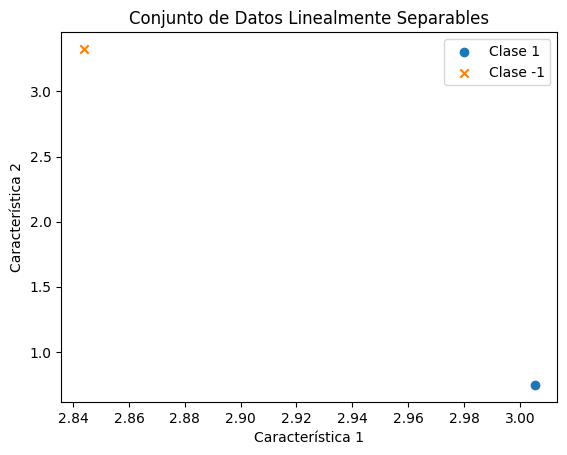

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# Generar un conjunto de datos linealmente separable
X, y = make_blobs(n_samples= 2, centers=2, n_features=2, random_state=0)

# Convertir las etiquetas a {-1, 1} para L1-SVM
y = 2 * y - 1

# Visualizar los datos
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Clase 1', marker='o')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Clase -1', marker='x')
plt.title('Conjunto de Datos Linealmente Separables')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()


Suponiendo que los pesos serán positivos

------------------------------------
Iteracion: 0
MATRIZ
[[ 1.     1.     1.     0.     0.     0.     0.   ]
 [ 0.    -3.005 -0.746 -1.     1.     0.    -1.   ]
 [ 0.     2.844  3.327  1.     0.     1.    -1.   ]]
------------------------------------
SIMPLEX DUAL
terminos independientes: [-1. -1.]
------------------------------------
Iteracion: 1
------------------------------------
Iteracion: 2
------------------------------------
Iteracion: 3
------------------------------------
Iteracion: 4
------------------------------------
Iteracion: 5
------------------------------------
Iteracion: 6
------------------------------------
Iteracion: 7
------------------------------------
Iteracion: 8
------------------------------------
Iteracion: 9
------------------------------------
Iteracion: 10
------------------------------------
Iteracion: 11
------------------------------------
Iteracion: 12
------------------------------------
Iteracion: 13
------------------------------------
Iteracion:

/tmp/ipykernel_134727/1014374055.py:268: RuntimeWarning: invalid value encountered in divide
  self.reglon_de_las_z / self.restricciones[columna_salida, :],


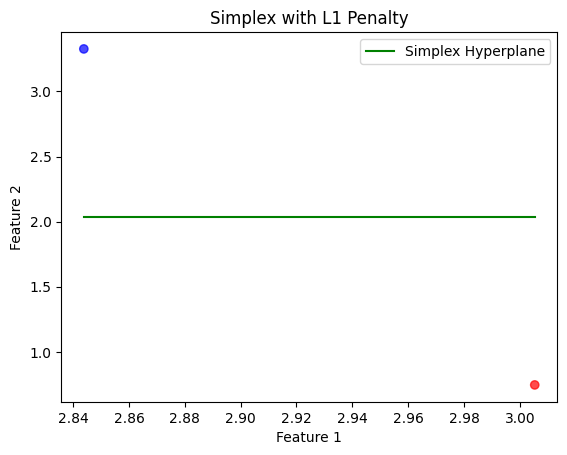

Simplex: 0 -0.7751328105398845 1.578486617383947
Distancias: [ 1. -1.]


In [138]:

tabla = np.stack([X[:, 0], X[:, 1], y], axis=1)

# Definir las variables y restricciones para Simplex
restricciones = "argmin z = 1x1 + 1x2 + 0x3 \n"

for i, fila in enumerate(tabla):
    z1, z2, label = fila
    restricciones += f"{label * z1}x1 + {label * z2}x2 + {label}x3 >= {1}\n"

maximo, variables, valores = Simplex(restricciones).resolucion(False)
dicc = dict(zip(variables, valores))
dicc = {k: dicc.get(k, 0) for k in ['x1', 'x2', 'x3']}

# Calcular el hiperplano de Simplex
w1, w2, b = dicc['x1'], dicc['x2'], dicc['x3']

# Crear el gráfico
if w2 == 0:
    # Calcular x para el hiperplano de decisión (hiperplano)
    x_hyperplane = -b / w1
    plt.axvline(x=x_hyperplane, color='green', linestyle='--', label='Decision Boundary')

else:
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = (-w1 / w2) * xx - b / w2

    plt.plot(xx, yy, label='Simplex Hyperplane', color='green')

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.7)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Simplex with L1 Penalty")
plt.show()
distancias = np.dot(tabla[:, :2], [w1, w2]) + b

print('Simplex:', w1, w2, b)
print('Distancias:', distancias)



SVC

Coeficientes SVC [[ 0.329 -0.51 ]] Intercept [0.]


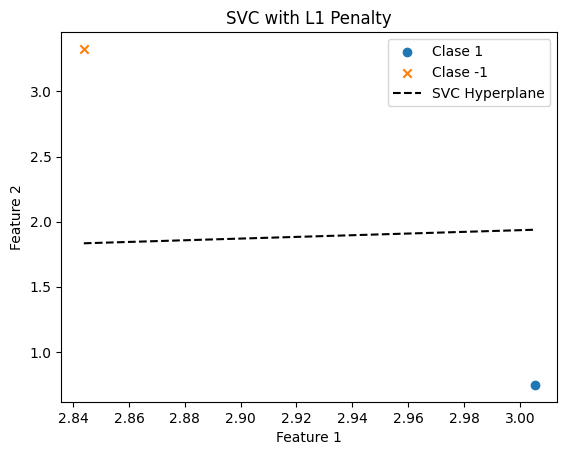

Distancias: [ 0.608 -0.762]


In [139]:
from sklearn.svm import LinearSVC as SVC

# Crear un clasificador SVM con regularización L1
clf = SVC(penalty='l1')
clf.fit(X, y)

# Obtener los coeficientes y el término independiente
w = clf.coef_[0]  # Coefficients
b2 = clf.intercept_[0]  # Intercept

# Crear el gráfico
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Clase 1', marker='o')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Clase -1', marker='x')

print('Coeficientes SVC', clf.coef_, 'Intercept', clf.intercept_)

if w[1] == 0:
    x_hyperplane = -b2 / w[0]    
    plt.axvline(x=x_hyperplane, color='black', linestyle='--', label='Decision Boundary')
else:
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy = (-w[0] / w[1]) * xx - b2 / w[1]
    plt.plot(xx, yy, 'k--', label='SVC Hyperplane')

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("SVC with L1 Penalty")
plt.show()

# imprimir la distancia de los puntos al hiperplano
distancias = clf.decision_function(X)
print('Distancias:', distancias)


Comparativa

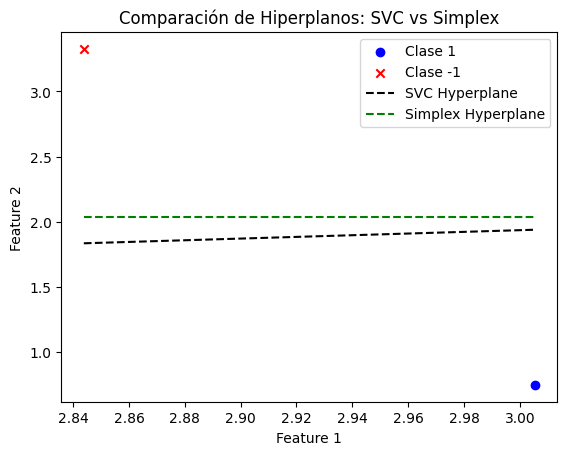

Distancias SVC: [ 0.608 -0.762]
Distancias Simplex: [-0.168 -0.748]


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC as SVC

# Crear el gráfico
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Clase 1', marker='o', color='blue')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Clase -1', marker='x', color='red')

# Graficar el hiperplano SVC
if w[1] == 0:
    x_hyperplane_svc = -b2 / w[0]
    plt.axvline(x=x_hyperplane_svc, color='black', linestyle='--', label='SVC Hyperplane', linewidth=3)
else:
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy_svc = (-w[0] / w[1]) * xx - b2 / w[1]
    plt.plot(xx, yy_svc, 'k--', label='SVC Hyperplane')

# Graficar el hiperplano de Simplex
if w2 == 0:
    x_hyperplane_simplex = -b / w1
    plt.axvline(x=x_hyperplane_simplex, color='green', label='Simplex Hyperplane', linewidth=5)

else:
    xx = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    yy_simplex = (-w1 / w2) * xx - b / w2
    plt.plot(xx, yy_simplex, 'g--', label='Simplex Hyperplane')

# Configuración final del gráfico
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Comparación de Hiperplanos: SVC vs Simplex")
plt.show()
# Imprimir las distancias de los puntos al hiperplano
distancias_svc = clf.decision_function(X)
distancias_simplex = np.dot(tabla[:, :2], [w1_simplex, w2_simplex]) + b_simplex

print('Distancias SVC:', distancias_svc)
print('Distancias Simplex:', distancias_simplex)


Con valor absoluto

------------------------------------
Iteracion: 0
MATRIZ
[[ 1.     1.    -1.    ...  0.     0.     0.   ]
 [ 0.    -1.39   1.39  ...  0.     0.    -1.   ]
 [ 0.     2.825 -2.825 ...  0.     0.    -1.   ]
 ...
 [ 0.     4.943 -4.943 ...  0.     0.    -1.   ]
 [ 0.    -0.467  0.467 ...  1.     0.    -1.   ]
 [ 0.     4.803 -4.803 ...  0.     1.    -1.   ]]
------------------------------------
SIMPLEX DUAL
terminos independientes: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
------------------------------------
Iteracion: 1
------------------------------------
Iteracion: 2
------------------------------------
Iteracion: 3
------------------------------------
Iteracion: 4
------------------------------------
Iteracion: 5
------------------------------------
Iteracion: 6
------------------------------------
Iteracion: 7
--------------

/tmp/ipykernel_134727/1014374055.py:268: RuntimeWarning: invalid value encountered in divide
  self.reglon_de_las_z / self.restricciones[columna_salida, :],


------------------------------------
Iteracion: 970
------------------------------------
Iteracion: 971
------------------------------------
Iteracion: 972
------------------------------------
Iteracion: 973
------------------------------------
Iteracion: 974
------------------------------------
Iteracion: 975
------------------------------------
Iteracion: 976
------------------------------------
Iteracion: 977
------------------------------------
Iteracion: 978
------------------------------------
Iteracion: 979
------------------------------------
Iteracion: 980
------------------------------------
Iteracion: 981
------------------------------------
Iteracion: 982
------------------------------------
Iteracion: 983
------------------------------------
Iteracion: 984
------------------------------------
Iteracion: 985
------------------------------------
Iteracion: 986
------------------------------------
Iteracion: 987
------------------------------------
Iteracion: 988
------------

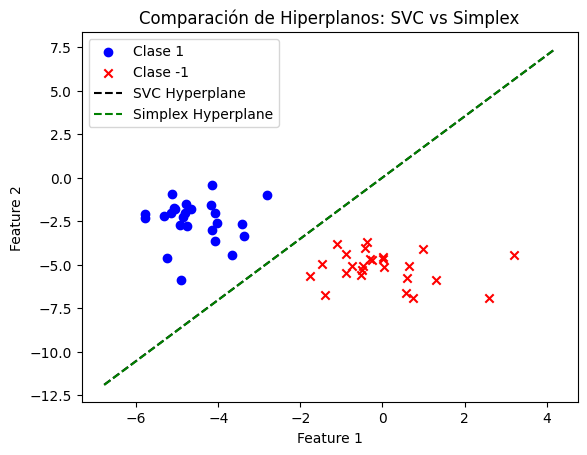

Distancias SVC: [-1.654  1.519 -1.792 -1.444 -2.913  2.706  2.436 -3.158  1.342  1.75
 -0.972 -1.991  2.382 -1.271  2.203  2.681 -4.393 -1.074 -1.588  2.621
 -0.726 -1.762  2.122 -2.374  2.73   1.054  2.757  0.968  3.078  1.962
 -1.489  1.628 -1.164  2.626 -1.806  0.756 -2.602  3.089  2.984 -1.686
  1.703 -3.137 -1.642 -3.853  1.279 -2.23  -0.902  2.282 -1.621  2.444]
Distancias Simplex: [-1.702  1.566 -1.845 -1.487 -3.     2.791  2.513 -3.253  1.385  1.806
 -1.    -2.051  2.456 -1.308  2.272  2.765 -4.526 -1.105 -1.636  2.702
 -0.747 -1.815  2.189 -2.445  2.815  1.089  2.843  1.     3.174  2.023
 -1.533  1.679 -1.198  2.708 -1.86   0.781 -2.681  3.185  3.077 -1.736
  1.757 -3.231 -1.691 -3.971  1.32  -2.298 -0.928  2.354 -1.669  2.521]


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC as SVC

# Generar un conjunto de datos linealmente separable
X, y = make_blobs(n_samples=50, centers=2, n_features=2, random_state=50)

# Convertir las etiquetas a {-1, 1} para L1-SVM
y = np.where(y == 0, -1, 1)

# Entrenar el modelo SVC
clf = SVC(penalty='l1', dual=False)
clf.fit(X, y)

# Extraer los parámetros del modelo SVC
w_svc = clf.coef_[0]  # Coeficientes SVC
b_svc = clf.intercept_[0]  # Intercepto SVC

# Calcular el hiperplano SVC
xx = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
if w_svc[1] != 0:
    yy_svc = (-w_svc[0] / w_svc[1]) * xx - b_svc / w_svc[1]
else:
    yy_svc = None  # Indica una línea vertical en caso de que el coeficiente sea 0

tabla = np.stack([X[:, 0], X[:, 1], y], axis=1)

restricciones = "argmin z = 1x1 + -1x2 + 1x3 + -1x4 + 0x5\n"

for i, fila in enumerate(tabla):
    z1, z2, label = fila
    restricciones += f"{label * z1}x1 + {-label * z1}x2 + {label * z2}x3 + {-label * z2}x4 + {label}x5 >= 1\n"

# Esta es una llamada hipotética a la función Simplex
# Suponemos que devuelve un diccionario `dicc` con las variables.
maximo, variables, valores = Simplex(restricciones).resolucion(False)
dicc = dict(zip(variables, valores))
dicc = {k: dicc.get(k, 0) for k in ['x1', 'x2', 'x3', 'x4', 'x5']}

print('dicc'    , dicc)
# Asumiendo que `dicc` tiene valores para w1, w2 y b
w1_simplex = dicc['x1'] - dicc['x2']
w2_simplex = dicc['x3'] - dicc['x4']
b_simplex = dicc['x5']

print('Coeficientes SVC', clf.coef_, 'Intercept', clf.intercept_)
print('Coeficientes Simplex', w1_simplex, w2_simplex, 'Intercept', b_simplex)

# Calcular el hiperplano de Simplex
if w2_simplex != 0:
    yy_simplex = (-w1_simplex / w2_simplex) * xx - b_simplex / w2_simplex
else:
    yy_simplex = None  # Indica una línea vertical en caso de que el coeficiente sea 0

# Crear el gráfico
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], label='Clase 1', marker='o', color='blue')
plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], label='Clase -1', marker='x', color='red')

# Graficar el hiperplano SVC
if yy_svc is not None:
    plt.plot(xx, yy_svc, 'k--', label='SVC Hyperplane')
else:
    x_hyperplane_svc = -b_svc / w_svc[0]
    plt.axvline(x=x_hyperplane_svc, color='black', linestyle='--', label='SVC Hyperplane')

# Graficar el hiperplano de Simplex
if yy_simplex is not None:
    plt.plot(xx, yy_simplex, 'g--', label='Simplex Hyperplane')
else:
    x_hyperplane_simplex = -b_simplex / w1_simplex
    plt.axvline(x=x_hyperplane_simplex, color='green', linestyle='--', label='Simplex Hyperplane')

# Configuración final del gráfico
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.title("Comparación de Hiperplanos: SVC vs Simplex")
plt.show()

# Imprimir las distancias de los puntos al hiperplano
distancias_svc = clf.decision_function(X)
distancias_simplex = np.dot(tabla[:, :2], [w1_simplex, w2_simplex]) + b_simplex

print('Distancias SVC:', distancias_svc)
print('Distancias Simplex:', distancias_simplex)


### Parte 2 (50% de la nota de la Práctica 1)

La segunda parte de esta práctica consiste en la realización de un ataque adversario a una
red neuronal. Los cuatro primeros ítems son obligatorios y sólo con ellos se puede obtener un
10 en esta parte 2 de la práctica uno. Sin embargo, hay una serie de puntos opcionales para
aquellos tengan interés en probar más cosas. Se recomienda usar pytorch o tensorflow para
la realización de esta parte. El proceso es el siguiente:

1. Entrena una red neuronal que clasifique con al menos un 95% de acierto el conjunto de
datos de MNIST. Elige una arquitectura diferente a la de clase, y asegúrate de que no
coincida con la de ningún otro grupo. Puedes utilizar para esto todas las librerías que
desees. Si se usa tensorflow, se recomienda usar el dataset importado desde la propia
librería con from tensorflow.keras.datasets import mnist. Identifica la cantidad
de parámetros de la arquitectura de tu red neuronal.



In [142]:
from tensorflow.keras.datasets import mnist
import torchvision.transforms as transforms
import torch
from tqdm import tqdm

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)


# Al ser imagenes, los mejores modelos son las redes convolucionales, 
# le pondremos aparte algunas capas de dropout
# y una capa de salida con 10 neuronas, una por cada digito

class MNISTModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.max_pool2d = torch.nn.MaxPool2d((2, 2))
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.conv3 = torch.nn.Conv2d(64, 128, 3, 1)
        self.conv4 = torch.nn.Conv2d(128, 256, 3, 1)
        self.max_pool2d2 = torch.nn.MaxPool2d((2, 2))
        self.dropout2 = torch.nn.Dropout2d(0.5)
        self.flatten = torch.nn.Flatten()  
        self.fc1 = torch.nn.Linear(4096, 128)
        self.dropout3 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.max_pool2d(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = torch.relu(x)
        x = self.max_pool2d2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        output = self.fc2(x)

        return output

model = MNISTModel().to(device)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
# normalizamos
X_train = X_train / 255
X_test = X_test / 255


# Convertimos a tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)


# Creamos el dataloader
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = torch.utils.data.DataLoader(train, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=1000, shuffle=False)

# funcion de perdida y optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ponemos early stopping para que pare cuando no mejore y guardamos el mejor modelo
best_loss = 1000
best_model = None
intentos = 10


for epoch in tqdm(range(1)):
    model.train()

    running_loss = 0.0
    for i, (data, target) in enumerate(train_loader):
        # Move data and target to GPU
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch}, Training loss: {running_loss / len(train_loader)}')

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()


        test_loss /= len(test_loader.dataset)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()

        print(f'Epoch: {epoch}, Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')

    if test_loss < best_loss:
        intentos = 10
    if test_loss > best_loss:
        intentos -= 1
        if intentos == 0:
            break



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Training loss: 0.649733570466439


100%|██████████| 1/1 [01:07<00:00, 67.93s/it]

Epoch: 0, Test set: Average loss: 0.0001, Accuracy: 9676/10000 (97%)


In [143]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    288     |
|  conv1.bias  |     32     |
| conv2.weight |   18432    |
|  conv2.bias  |     64     |
| conv3.weight |   73728    |
|  conv3.bias  |    128     |
| conv4.weight |   294912   |
|  conv4.bias  |    256     |
|  fc1.weight  |   524288   |
|   fc1.bias   |    128     |
|  fc2.weight  |    1280    |
|   fc2.bias   |     10     |
+--------------+------------+
Total Trainable Params: 913546


913546

In [144]:
import numpy as np
# mostramos la cantidad de parametros
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)


913546


2. Entrena una SVM con núcleo Gaussiano para MNIST. Puedes utilizar para esto todas
las librerías que desees.

In [145]:
# importamos SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.datasets import mnist

classifier = SVC(kernel='rbf', random_state=42)

# Cargamos el dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.00
x_test = x_test / 255.0

# entrenamos con mnist
classifier.fit(x_train.reshape(-1, 784), y_train)
y_pred_svm = classifier.predict(x_test.reshape(-1, 784))
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm) * 100:.2f}%')


Accuracy: 97.92%




3. Genera una función que haga un ataque de tipo FGSM a la red neuronal. Si existe una
librería de python específica para esto, no se puede usar, pero sí se puede usar (y es
recomendable) usar funciones que te ayuden a para calcular los gradientes dentro de la
función signo, (por ejemplo la función GradienTape de tensorflow).

In [146]:
def fgsm_attack(image, epsilon, data_grad):
    # Obtener el signo del gradiente
    sign_data_grad = data_grad.sign()
    # Crear la imagen perturbada
    perturbed_image = image + epsilon * sign_data_grad
    # Clip values to [0, 1]
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


4. Genera unas cuantas imágenes adversarias y trata de predecirlas tanto con tu red neuronal
como con la SVM. Visualiza tanto las originales como las adversarias.

In [147]:
# Helper function to visualize images and predictions
import matplotlib.pyplot as plt

def visualize_images(original, adversarial, cnn_original_pred, cnn_adversarial_pred, svm_original_pred, svm_adversarial_pred):
    # Calculate the noise (difference between adversarial and original images)
    noise = adversarial - original
    noise = noise.detach().cpu().numpy().squeeze()
    
    # Set up subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    # Display original image with predictions
    axs[0].imshow(original.detach().cpu().numpy().squeeze(), cmap='gray')
    axs[0].set_title(f'Original\nCNN: {cnn_original_pred} | SVM: {svm_original_pred}')
    axs[0].axis('off')
    
    # Display adversarial image with predictions
    axs[1].imshow(adversarial.detach().cpu().numpy().squeeze(), cmap='gray')
    axs[1].set_title(f'Adversarial\nCNN: {cnn_adversarial_pred} | SVM: {svm_adversarial_pred}')
    axs[1].axis('off')
    
    # Display the noise image
    axs[2].imshow(noise, cmap='gray')
    axs[2].set_title('Noise (Perturbation)')
    axs[2].axis('off')
    
    plt.show()


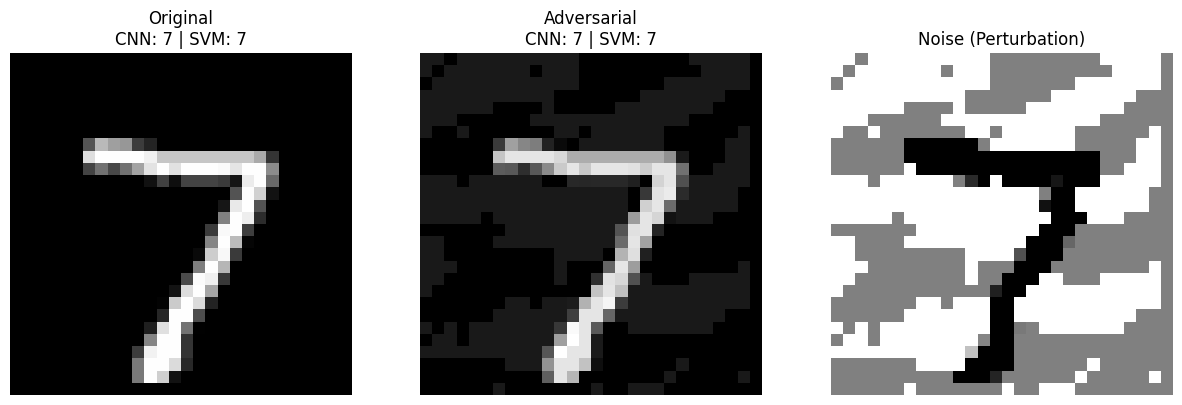

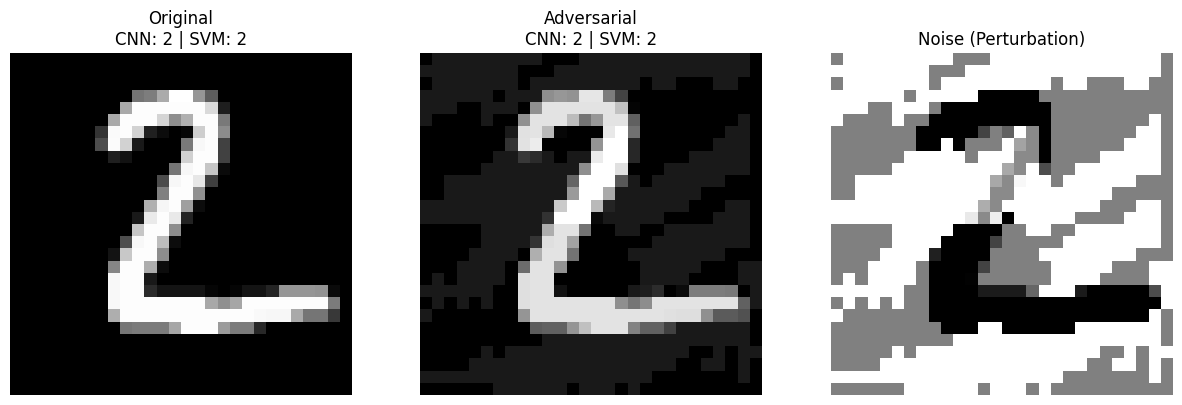

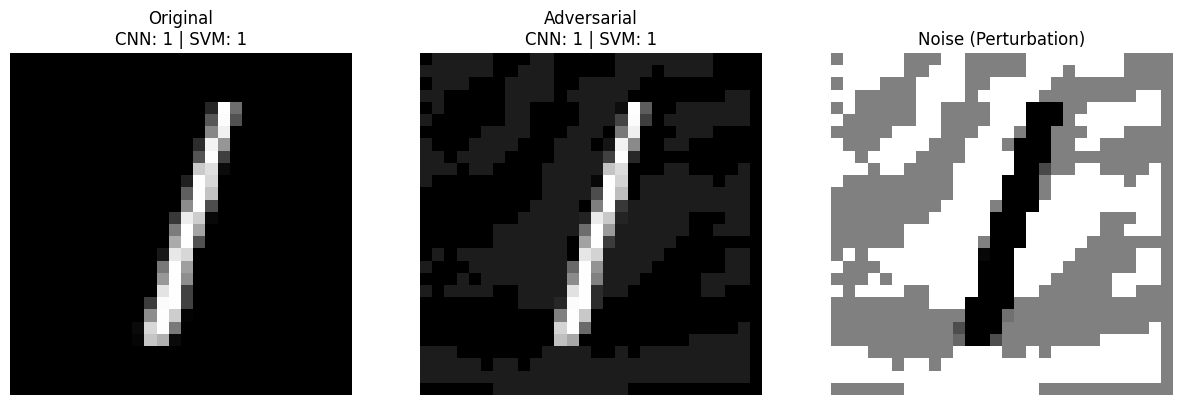

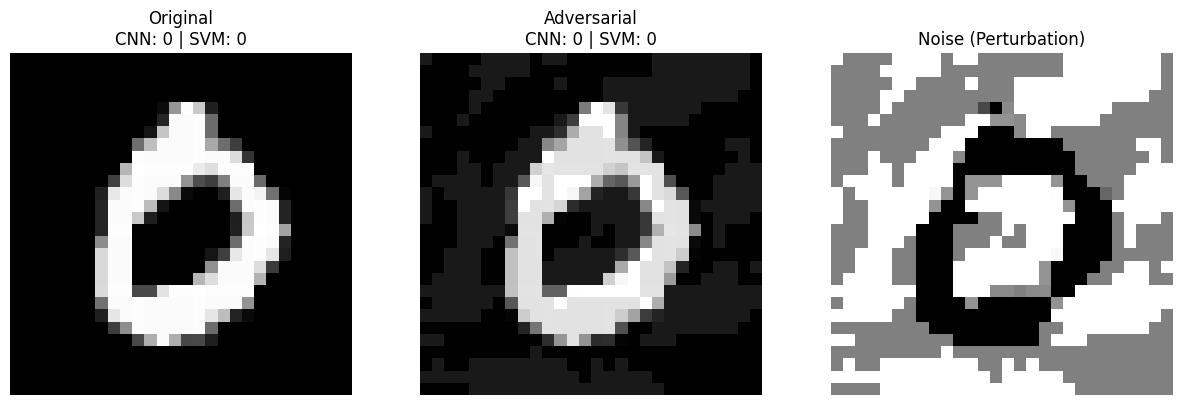

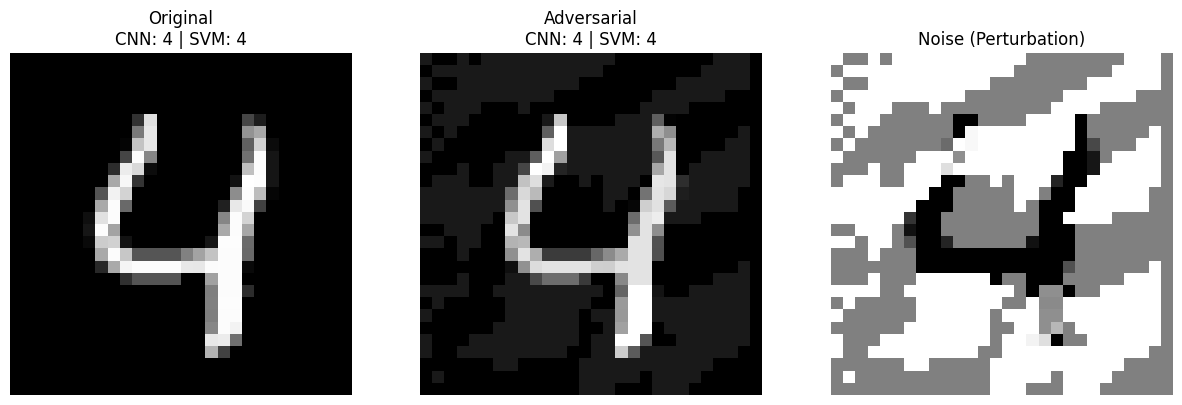

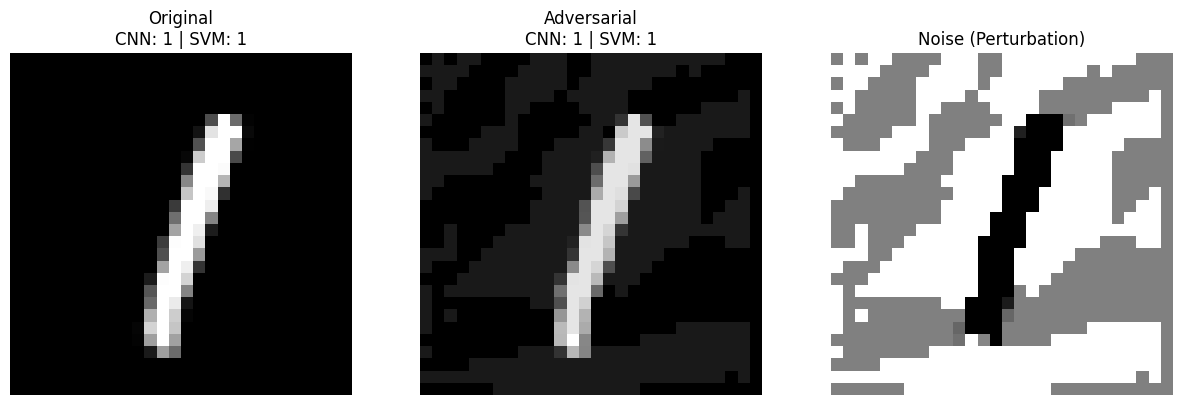

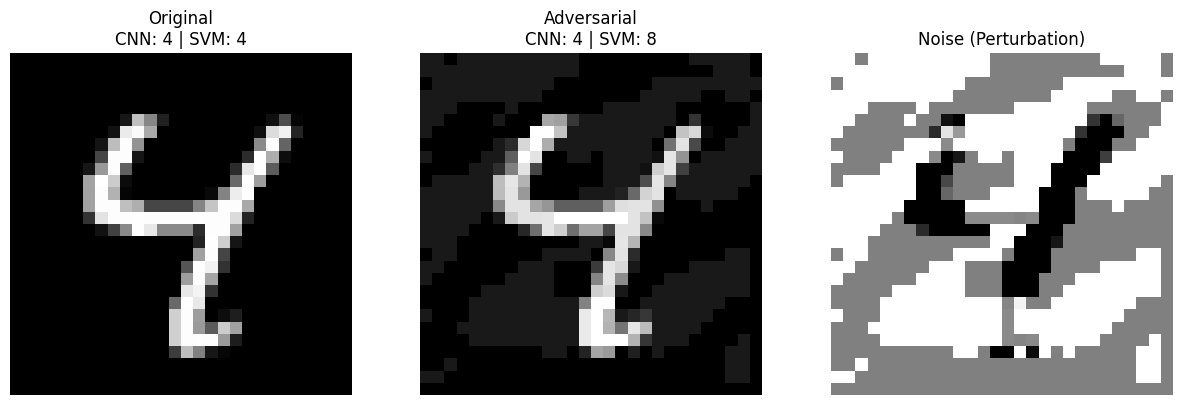

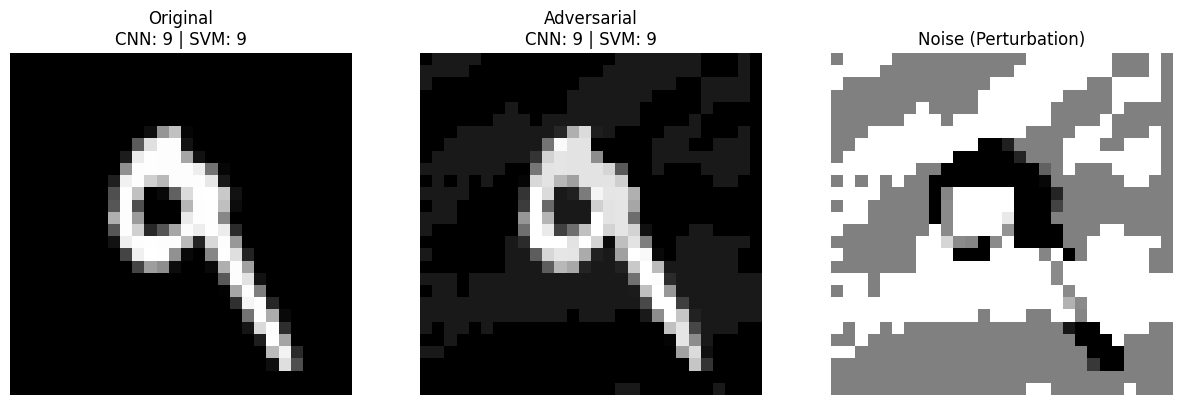

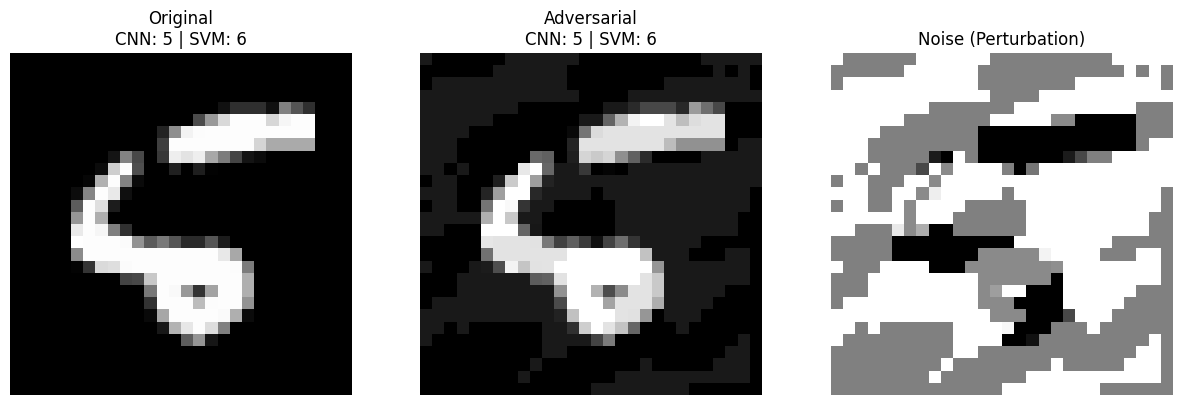

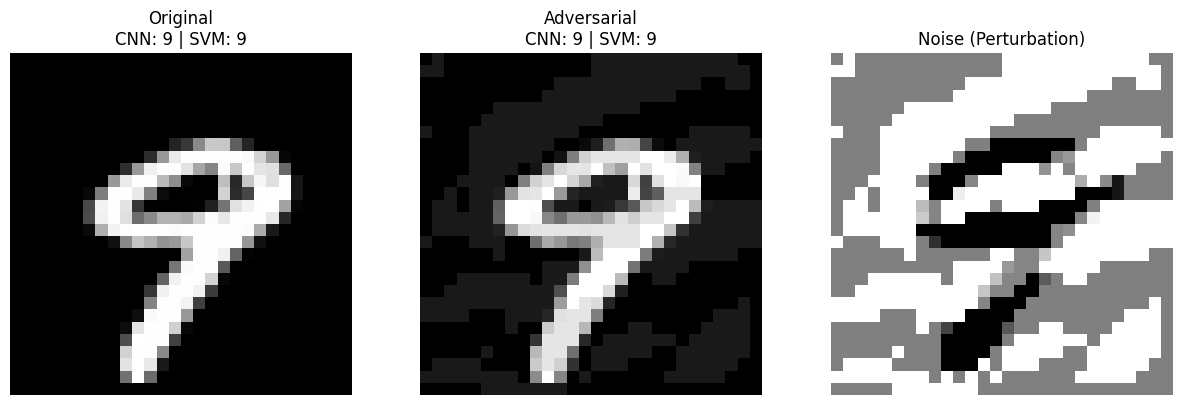

Aciertos: 10/10


In [148]:
"""
Cargamos 10 imagenes y creamos sus imagenes adversarias para prededir con el modelo
"""
aciertos = 0
total_samples = 10

epsilon = 0.1
model.eval()
for i in range(total_samples):

    # Obtenemos la imagen y la etiqueta
    image = X_test[i].unsqueeze(0).to(device)
    label = y_test[i].item()

    # Predecimos la imagen original con el modelo CNN
    output = model(image)
    _, cnn_original_pred = torch.max(output, 1)
    cnn_original_pred = cnn_original_pred.item()

    # Se calcula el gradiente de la imagen
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, torch.tensor([label]).to(device))
    loss.backward()
    data_grad = image.grad.data

    # Generamos la imagen adversaria
    perturbed_image = fgsm_attack(image, epsilon, data_grad)

    # Predecimos con el modelo CNN
    output = model(perturbed_image)
    _, cnn_adversarial_pred = torch.max(output, 1)
    cnn_adversarial_pred = cnn_adversarial_pred.item()

    # Predecimos con el modelo SVM
    svm_original_pred = classifier.predict(image.detach().numpy().reshape(1, 784))[0]
    svm_adversarial_pred = classifier.predict(perturbed_image.cpu().detach().reshape(1, 784))[0]

    visualize_images(image, perturbed_image, cnn_original_pred, cnn_adversarial_pred, svm_original_pred, svm_adversarial_pred)

    aciertos += cnn_adversarial_pred == label

print(f'Aciertos: {aciertos}/{total_samples}')




5. (Opcional) Genera imágenes adversarias para todo el conjunto de train y/o test de MNIST
y establece el error de cada uno de los dos modelos sobre este conjunto adversario.






In [149]:
import os
import torch
from torchvision.utils import save_image
from tqdm import tqdm

import torchvision.transforms as transforms

if not os.path.exists('adversariales'):
    os.makedirs('adversariales')
    for i in range(10):
        os.makedirs(f'adversariales/{i}')

epsilon = 0.1

model.eval()

for i, (data, target) in enumerate(tqdm(test_loader)):
    data, target = data.to(device), target.to(device)

    data.requires_grad = True

    output = model(data)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    for j in range(perturbed_data.size(0)):
        clase = target[j].item()
        save_image(perturbed_data[j],
                   f'adversariales/{clase}/adversarial_{i * test_loader.batch_size + j}.png')



100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


In [150]:
import torchvision

In [151]:

cnn_adversarial_preds = []
svm_adversarial_preds = []

path = 'adversariales'
# normalizar y cambiar a un canal
adversarial_dataset = torchvision.datasets.ImageFolder(path, 
    transform=transforms.Compose([transforms.ToTensor(), 
              transforms.Grayscale(num_output_channels=1)])
)
adversarial_loader = torch.utils.data.DataLoader(adversarial_dataset, batch_size=1000, shuffle=False)
y_test = adversarial_dataset.targets

model.eval()
for data, target in tqdm(adversarial_loader):

    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        adversarial_pred_cnn = model(data).argmax(1)
        cnn_adversarial_preds.extend(adversarial_pred_cnn.cpu().numpy())

    adversarial_pred_svm = classifier.predict(data.cpu().detach().numpy().reshape(-1, 784))
    svm_adversarial_preds.extend(adversarial_pred_svm)



# Calculate the accuracy on adversarial images
cnn_adversarial_accuracy = accuracy_score(y_test, cnn_adversarial_preds)
svm_adversarial_accuracy = accuracy_score(y_test, svm_adversarial_preds)
print(f'CNN Adversarial Accuracy: {cnn_adversarial_accuracy * 100:.2f}%')
print(f'SVM Adversarial Accuracy: {svm_adversarial_accuracy * 100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:59<00:00,  5.92s/it]

CNN Adversarial Accuracy: 84.17%
SVM Adversarial Accuracy: 88.39%


6. (Opcional) Entrena adversariamente, es decir, entrena tus dos modelos con las 120.000
imágenes; 60.000 originales y 60.000 adversarias. Calcula el error en el test conjunto
(20.000 imágenes, originales y adversarias).

In [152]:
# sacamos las imagenes adversariales de train
if not os.path.exists('adversariales_train'):
    os.makedirs('adversariales_train')
    for i in range(10):
        os.makedirs(f'adversariales_train/{i}')

epsilon = 0.1

model.eval()

for i, (data, target) in enumerate(tqdm(train_loader)):
    data, target = data.to(device), target.to(device)

    data.requires_grad = True

    output = model(data)
    loss = criterion(output, target)

    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data

    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    for j in range(perturbed_data.size(0)):
        clase = target[j].item()
        save_image(perturbed_data[j],
                   f'adversariales_train/{clase}/adversarial_{i * train_loader.batch_size + j}.png')

100%|██████████| 60/60 [01:15<00:00,  1.25s/it]


In [153]:
from torch.utils.data import ConcatDataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision
import torch

path = 'adversariales_train'
path_test = 'adversariales'

image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1)
])
label_transform = transforms.Lambda(lambda y: torch.tensor(y, dtype=torch.int64)) 

adversarial_dataset = torchvision.datasets.ImageFolder(
    path,
    transform=image_transform,
    target_transform=label_transform
)

adversarial_dataset_test = torchvision.datasets.ImageFolder(
    path_test,
    transform=image_transform,
    target_transform=label_transform
)

(x_train_original, y_train_original), (x_test_original, y_test_original) = mnist.load_data()
x_train_original = x_train_original / 255.0
x_test_original = x_test_original / 255.0

x_train_original = torch.tensor(x_train_original, dtype=torch.float32).unsqueeze(1)  # Shape: [N, 1, 28, 28]
x_test_original = torch.tensor(x_test_original, dtype=torch.float32).unsqueeze(1)    # Shape: [N, 1, 28, 28]
y_train_original = torch.tensor(y_train_original, dtype=torch.int64)
y_test_original = torch.tensor(y_test_original, dtype=torch.int64)

train_original = TensorDataset(x_train_original, y_train_original)
test_original = TensorDataset(x_test_original, y_test_original)

train_dataset_all = ConcatDataset([train_original, adversarial_dataset])
test_dataset_all = ConcatDataset([test_original, adversarial_dataset_test])

train_loader_all = DataLoader(train_dataset_all, batch_size=1000, shuffle=True)
test_loader_all = DataLoader(test_dataset_all, batch_size=1000, shuffle=False)


In [154]:

# Entrenamos el modelo con las imagenes originales y adversariales

model = MNISTModel().to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

best_loss = 1000
intentos = 10

for epoch in tqdm(range(1)):
    model.train()
    running_loss = 0.0
    for (data, target) in train_loader_all:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch: {epoch}, Training loss: {running_loss / len(train_loader_all)}')

    model.eval()
    with torch.no_grad():
        test_loss = 0
        correct = 0
        for data, target in test_loader_all:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(test_loader_all.dataset)
        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()

        print(f'Epoch: {epoch}, Test set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader_all.dataset)} ({100. * correct / len(test_loader_all.dataset):.0f}%)')

    if test_loss < best_loss:
        intentos = 10
    if test_loss > best_loss:
        intentos -= 1
        if intentos == 0:
            break

model.load_state_dict(best_model)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0, Training loss: 0.364610427405153


100%|██████████| 1/1 [03:23<00:00, 203.17s/it]

Epoch: 0, Test set: Average loss: 0.0000, Accuracy: 19789/20000 (99%)


<All keys matched successfully>

In [155]:
model.eval()

cnn_preds = 0
svm_preds = 0

with torch.no_grad():
    for data, target in tqdm(test_loader_all):
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(1)

        svm_pred = classifier.predict(data.cpu().detach().numpy().reshape(-1, 784))
        
        cnn_preds += pred.eq(target).sum().item()
        svm_preds += np.sum(svm_pred == target.cpu().numpy())

cnn_accuracy = cnn_preds / len(test_loader_all.dataset)
svm_accuracy = svm_preds / len(test_loader_all.dataset)

print(f'CNN Accuracy: {cnn_accuracy * 100:.2f}%')
print(f'SVM Accuracy: {svm_accuracy * 100:.2f}%')

100%|██████████| 20/20 [01:54<00:00,  5.74s/it]

CNN Accuracy: 98.95%
SVM Accuracy: 93.16%


7. (Opcional) Ataca a las 60.000 imágenes adversarias, obteniendo 60.000 imágenes “doblemente adversarias”. ¿Qué rendimiento obtiene el modelo entrenado adversariamente sobre
las imágenes “doblemente adversarias”?


In [156]:
epsilon = 0.1
model.eval()
cnn_predictions = []
svm_predictions = []
y_test = adversarial_loader.dataset.targets

model.eval()
for data, target in tqdm(adversarial_loader):
    data, target = data.to(device), target.to(device)

    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    doubly_adversarial_data = fgsm_attack(data, epsilon, data_grad)

    with torch.no_grad():
        cnn_predictions.append(model(doubly_adversarial_data).argmax(dim=1))
        svm_predictions.append(classifier.predict(doubly_adversarial_data.view(doubly_adversarial_data.size(0), -1).cpu().numpy()))

cnn_predictions = torch.cat(cnn_predictions).cpu().numpy() 
svm_predictions = np.concatenate(svm_predictions)

cnn_accuracy = np.mean(cnn_predictions == y_test)
svm_accuracy = np.mean(svm_predictions == y_test)

print(f"CNN accuracy on doubly adversarial images: {cnn_accuracy}")
print(f"SVM accuracy on doubly adversarial images: {svm_accuracy}")

100%|██████████| 10/10 [01:08<00:00,  6.80s/it]

CNN accuracy on doubly adversarial images: 0.2595
SVM accuracy on doubly adversarial images: 0.9184


  0%|          | 0/10 [00:00<?, ?it/s]

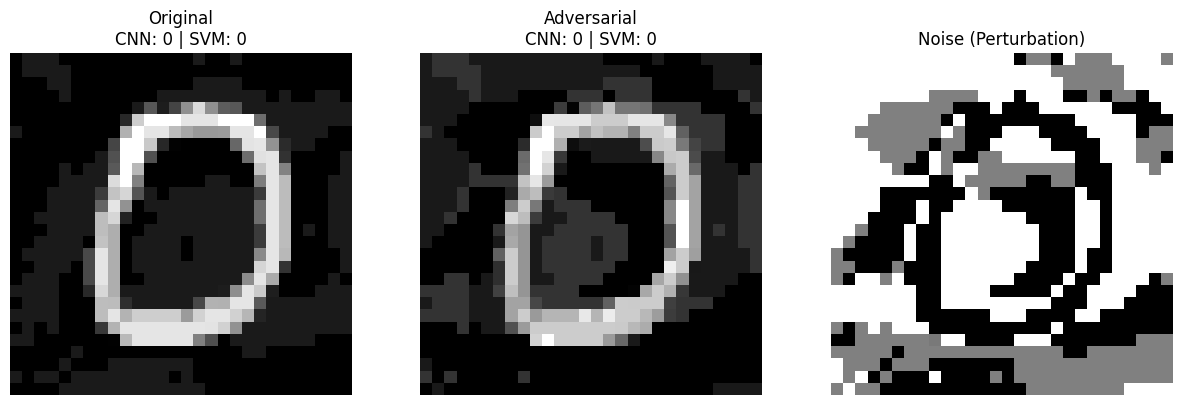

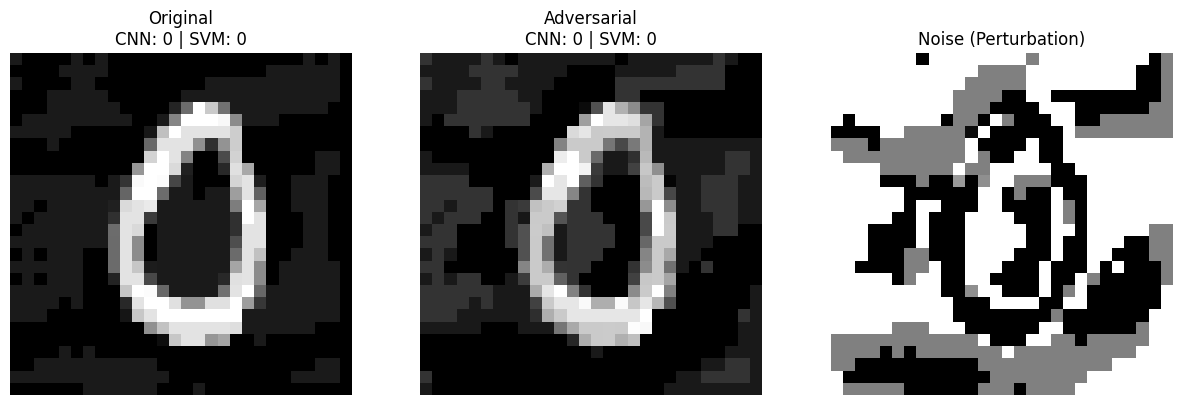

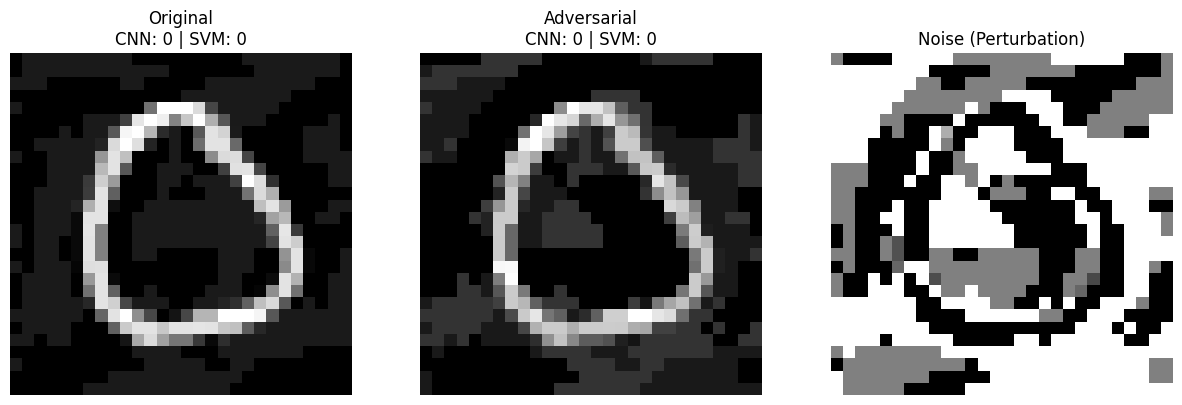

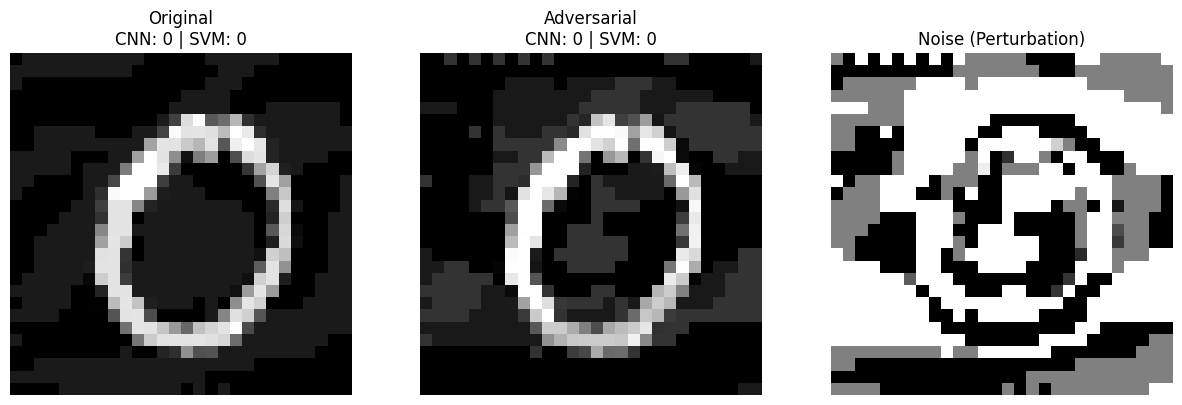

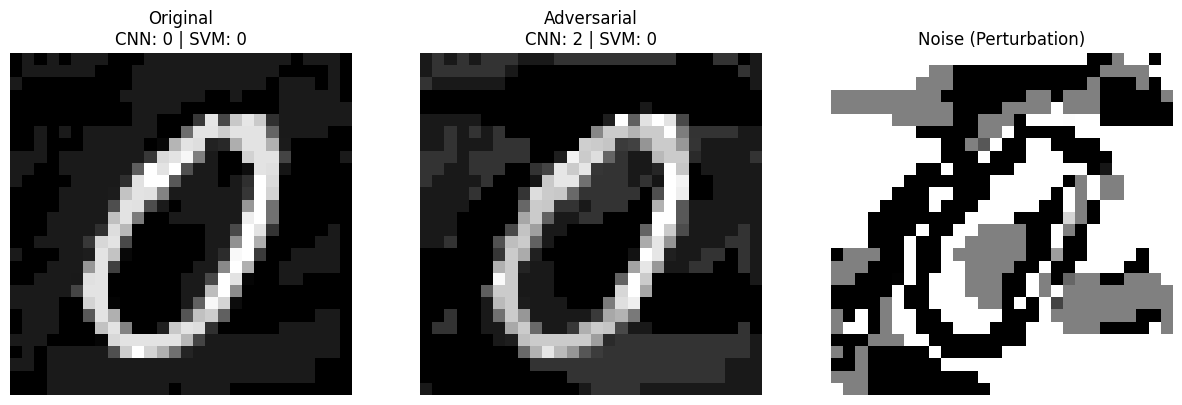

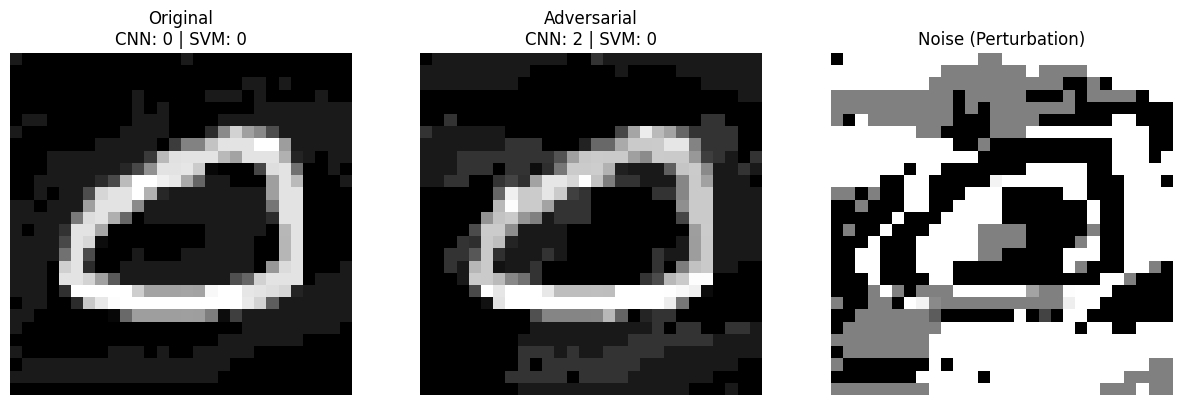

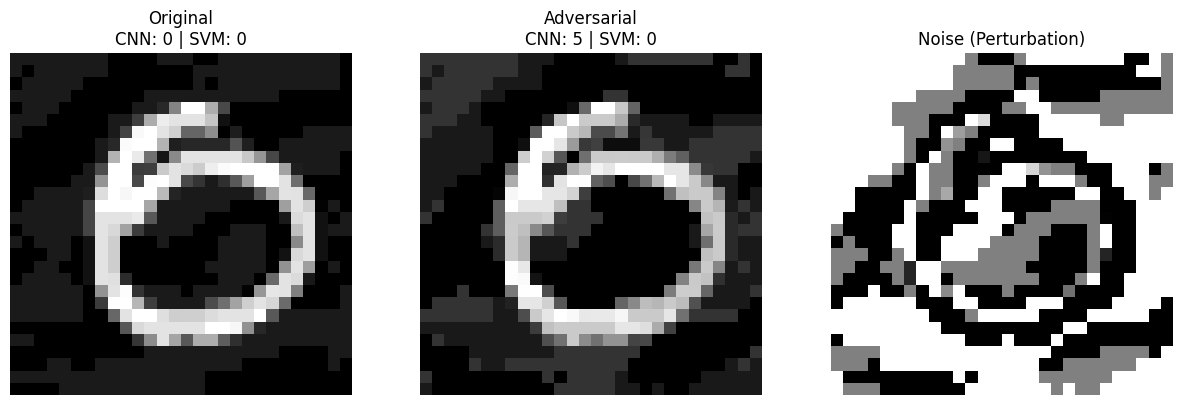

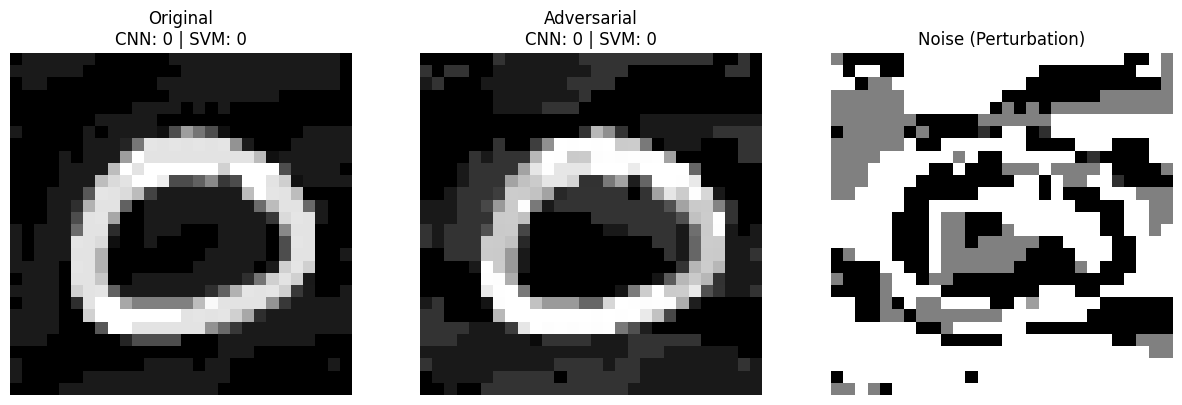

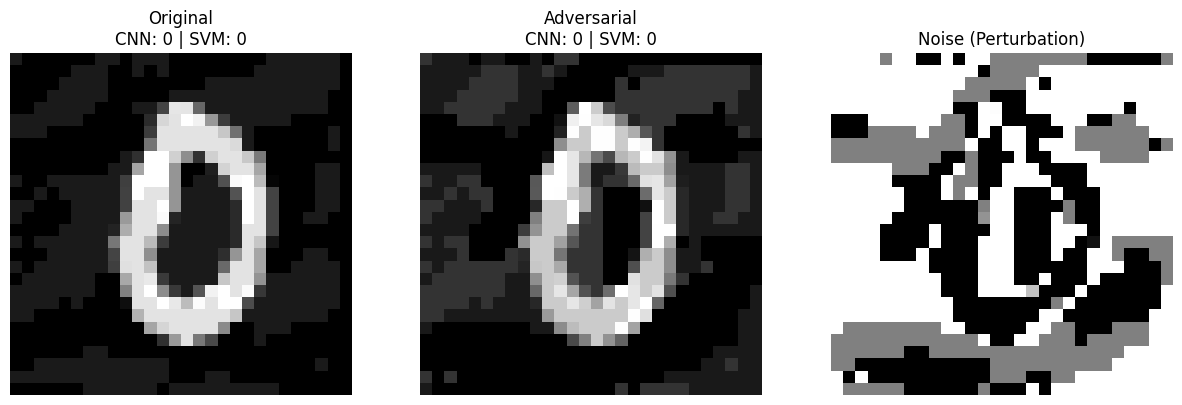

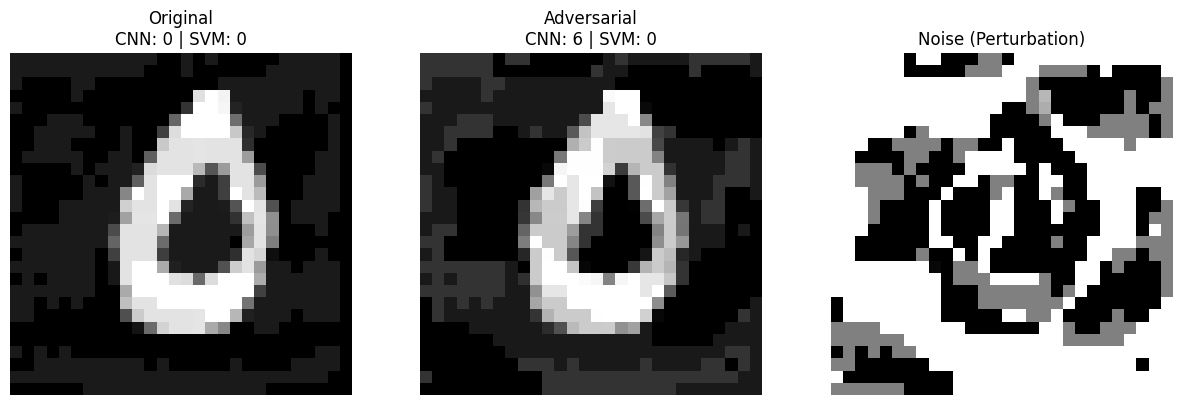

  0%|          | 0/10 [00:01<?, ?it/s]


In [157]:
# mostrar imagenes doblemente adversariales

images = 10

for data, target in tqdm(adversarial_loader):

    for i in range(images):
        image = data[i].unsqueeze(0).to(device)
        label = target[i].item()

        image.requires_grad = True
        output = model(image)
        loss = criterion(output, torch.tensor([label]).to(device))
        loss.backward()
        data_grad = image.grad.data
        perturbed_image = fgsm_attack(image, epsilon, data_grad)

        cnn_pred = model(perturbed_image).argmax(1).item()
        svm_pred = classifier.predict(perturbed_image.cpu().detach().numpy().reshape(1, 784))[0]

        visualize_images(image, perturbed_image, label, cnn_pred, label, svm_pred)

        if i == images - 1:
            break

    break